# Reproducing Hakim CDA Study (2019) - Left vs Right

In [1]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_brainvision

from scipy.io import loadmat

from autoreject import AutoReject

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Hakim-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [3]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

# --------------------------
triggers['2'] = [2, 3]
triggers['4'] = [4, 5]

triggers['left'] = [3, 5]   #[2, 4]
triggers['right'] = [2, 4]  #[3, 5]

triggers['good'] = [91]
triggers['bad'] = [90]

# Labels
conds = ['2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['O2', 'PO4', 'PO8', 'P4', 'P8']
chan_left = ['O1', 'PO3', 'PO7', 'P3', 'P7']

# Epoch Information
epoch_length = 1.4
epoch_tmin = -0.4
baseline_corr = (-0.4, 0)

# CDA main variable!
cda_dict = dict()
cda_dict_clean = dict()
report = prep_report(conds, sides, perfs)


#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
experiences = ['Exp1a', 'Exp1b', 'Exp2a', 'Exp2b'] 

eegfiles = []
for cur_exp in experiences:
    folderpath = '/Volumes/Nick - Data/CDA Datasets/Hakim 2019/{}/EEGData/**/*.vhdr'.format(cur_exp)
    for filepath in glob.glob(folderpath, recursive=True):
        eegfiles.append(filepath)

for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_brainvision(filepath, preload=True)
        
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    preproc = raw

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)
    events = events[0]
    
    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # X. -- CLEANING! --
    # ------------------------
    ar = AutoReject()

    # Flatten epochs to clean all at once.
    epochs_dict_clean = dict()
    epochs_to_clean = []
    for c in epochs_dict.keys():
        epochs_dict_clean[c] = dict()
        for s in epochs_dict[c].keys():
            epochs_dict_clean[c][s] = dict()
            for p in ['good']:#epochs_dict[c][s].keys():
                epochs_dict_clean[c][s][p] = []
                epochs_to_clean.append(epochs_dict[c][s][p])

    len(epochs_to_clean)

    cleaned_epochs = ar.fit_transform(mne.concatenate_epochs(epochs_to_clean)) 

    # Reconstruct epochs                
    for cond in conds:
        for t in triggers[cond]:
            for side in sides:
                if t in triggers[side]:
                    cur_side = side

            epochs_dict_clean[cond][cur_side]['good'].append(cleaned_epochs[str(t)])

    # Concatenate Epochs into Epochs MNE structure (from a list of Epochs because of diff triggers)
    for cond in conds:
        for side in sides:
            epochs_dict_clean[cond][side]['good'] = mne.concatenate_epochs(epochs_dict_clean[cond][side]['good'])
            
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict_clean)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = get_CDA(epochs_dict_clean, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['2']['left']['good'].times

print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: 10_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/10/10_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5127809  =      0.000 ... 10255.618 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 154 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
46 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 46 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=4



Dropped 34 epochs: 4, 27, 40, 42, 64, 94, 107, 147, 150, 153, 175, 210, 213, 221, 226, 247, 249, 262, 277, 281, 302, 346, 408, 412, 426, 429, 433, 436, 464, 494, 501, 523, 535, 539
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 11_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/11/11_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4493109  =      0.000 ...  8986.218 sec

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=1



Dropped 28 epochs: 26, 30, 53, 104, 145, 153, 159, 165, 199, 228, 234, 282, 287, 291, 321, 336, 341, 370, 424, 467, 493, 590, 616, 627, 629, 634, 639, 649
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 12_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/12/12_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4485929  =      0.000 ...  8971.858 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=4



Dropped 159 epochs: 4, 7, 8, 11, 28, 29, 36, 40, 42, 44, 48, 51, 58, 59, 64, 71, 72, 74, 75, 79, 80, 81, 82, 88, 90, 95, 96, 97, 100, 101, 105, 108, 109, 111, 118, 119, 120, 121, 122, 125, 126, 130, 131, 132, 133, 134, 137, 142, 146, 147, 148, 155, 158, 159, 163, 165, 166, 167, 169, 170, 174, 175, 176, 177, 179, 180, 187, 191, 202, 218, 219, 220, 222, 226, 230, 235, 238, 244, 252, 253, 254, 257, 259, 260, 262, 263, 269, 273, 274, 281, 282, 284, 285, 286, 292, 296, 300, 301, 309, 312, 318, 322, 323, 330, 331, 332, 335, 336, 337, 340, 341, 350, 355, 357, 360, 361, 362, 364, 365, 367, 372, 375, 376, 377, 378, 405, 409, 414, 429, 434, 436, 437, 439, 444, 453, 469, 477, 482, 507, 512, 520, 526, 533, 538, 551, 552, 605, 608, 614, 633, 635, 657, 665, 681, 682, 686, 694, 695, 716
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=1.00 and n_interpolate=30



Dropped 1 epoch: 132
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 15_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/15/15_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5535679  =      0.000 ... 11071.358 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.70 and n_interpolate=4



Dropped 5 epochs: 150, 236, 375, 376, 452
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
111 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 16_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/16/16_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4127859  =      0.000 ...  8255.718 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=1



Dropped 62 epochs: 5, 21, 22, 37, 40, 66, 68, 72, 78, 101, 103, 105, 195, 222, 239, 265, 271, 272, 277, 291, 342, 345, 364, 365, 370, 373, 393, 400, 434, 444, 448, 452, 461, 465, 467, 468, 469, 493, 496, 497, 506, 509, 514, 521, 527, 529, 530, 546, 548, 562, 570, 583, 598, 617, 630, 632, 642, 670, 676, 685, 691, 694
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 17_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/H

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 51 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=1



Dropped 15 epochs: 15, 27, 30, 63, 82, 85, 98, 108, 243, 245, 262, 303, 432, 474, 478
Not setting metadata
Not setting metadata
141 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 18_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/18/18_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 3989099  =      0.000 ...  7978.198 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.90 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 20_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/20/20_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4166669  =      0.000 ...  8333.338 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 15 epochs: 39, 64, 121, 173, 184, 255, 266, 313, 337, 378, 450, 463, 584, 612, 624
Not setting metadata
Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 21_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/21/21_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4689049  =      0.000 ...  9378.098 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 10 epochs: 76, 98, 186, 345, 375, 376, 380, 525, 651, 674
Not setting metadata
Not setting metadata
192 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 22_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/22/22_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4232319  =      0.000 ...  8464.638 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=4



Dropped 53 epochs: 21, 32, 33, 34, 36, 38, 42, 74, 103, 118, 121, 122, 123, 124, 125, 136, 148, 165, 183, 184, 185, 187, 256, 264, 276, 277, 278, 279, 338, 339, 340, 341, 342, 343, 344, 348, 354, 376, 390, 401, 414, 415, 418, 429, 430, 453, 454, 455, 486, 488, 532, 535, 561
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 23_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/23/23_WM_att_NHKA.v

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 153 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 28 epochs: 26, 97, 103, 115, 118, 129, 133, 151, 152, 218, 223, 251, 271, 272, 277, 278, 327, 359, 409, 429, 438, 446, 451, 491, 495, 497, 507, 532
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 24_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/24/24_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5455419  =      0.000 ... 10910.838 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.60 and n_interpolate=1



Dropped 71 epochs: 2, 25, 65, 70, 82, 86, 100, 103, 111, 119, 120, 124, 133, 137, 162, 192, 195, 200, 202, 208, 215, 216, 217, 223, 224, 225, 227, 238, 243, 249, 255, 258, 263, 264, 266, 267, 271, 272, 273, 274, 276, 283, 295, 300, 322, 345, 373, 379, 382, 383, 391, 394, 395, 398, 399, 402, 432, 433, 435, 439, 440, 485, 489, 491, 493, 494, 495, 497, 504, 505, 506
Not setting metadata
Not setting metadata
129 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
95 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 25_WM_att_NHKA.vhdr...
Extracting para

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=4



Dropped 13 epochs: 0, 7, 33, 143, 166, 217, 256, 397, 426, 431, 443, 536, 619
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
185 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 28_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/28/28_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5826979  =      0.000 ... 11653.958 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 150 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 50 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=1.00 and n_interpolate=4



Dropped 3 epochs: 88, 449, 543
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 29_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/29/29_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4759719  =      0.000 ...  9519.438 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=1



Dropped 13 epochs: 61, 71, 89, 91, 245, 247, 261, 430, 432, 433, 436, 584, 619
Not setting metadata
Not setting metadata
187 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 31_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/31/31_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4397369  =      0.000 ...  8794.738 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.10 and n_interpolate=1



Dropped 218 epochs: 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18, 26, 42, 52, 55, 62, 65, 66, 67, 74, 76, 79, 84, 85, 86, 87, 88, 91, 103, 110, 114, 116, 118, 121, 124, 126, 127, 128, 131, 135, 141, 143, 146, 148, 149, 150, 153, 154, 155, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 176, 177, 183, 196, 197, 207, 208, 211, 214, 219, 224, 231, 234, 240, 241, 242, 243, 245, 246, 247, 251, 253, 260, 261, 262, 263, 265, 267, 271, 273, 276, 277, 280, 281, 284, 287, 296, 299, 300, 301, 302, 304, 305, 306, 310, 314, 315, 316, 318, 323, 324, 325, 330, 331, 334, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 348, 349, 351, 355, 366, 367, 375, 381, 383, 384, 388, 389, 390, 393, 395, 396, 398, 407, 408, 409, 410, 411, 412, 414, 419, 420, 431, 433, 436, 437, 438, 441, 442, 446, 447, 448, 450, 452, 455, 456, 460, 464, 466, 467, 468, 469, 470, 471, 472, 473, 475, 476, 478, 479, 499, 501, 512, 515, 516, 518, 521, 526, 527, 528, 529, 533, 534, 535, 537, 540, 543, 544

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
191 matchi







Estimated consensus=0.40 and n_interpolate=4



Dropped 93 epochs: 1, 6, 9, 10, 29, 38, 45, 48, 57, 58, 59, 66, 71, 80, 90, 101, 113, 118, 120, 122, 126, 131, 135, 137, 148, 150, 151, 155, 172, 194, 196, 198, 204, 209, 219, 235, 244, 281, 283, 315, 320, 322, 326, 327, 330, 332, 333, 335, 350, 352, 376, 383, 387, 388, 404, 424, 425, 428, 448, 449, 485, 487, 488, 493, 495, 497, 504, 514, 519, 522, 528, 529, 544, 546, 550, 553, 557, 565, 569, 570, 577, 579, 580, 593, 606, 608, 615, 624, 645, 647, 650, 654, 655
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
197 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 197 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.10 and n_interpolate=1



Dropped 279 epochs: 10, 13, 15, 18, 19, 20, 21, 24, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 81, 83, 84, 85, 86, 89, 90, 91, 92, 93, 94, 96, 97, 98, 100, 101, 102, 103, 107, 108, 110, 111, 114, 115, 117, 119, 122, 130, 134, 145, 146, 171, 185, 189, 201, 202, 203, 204, 205, 206, 207, 212, 213, 214, 215, 218, 219, 221, 222, 231, 232, 233, 235, 236, 237, 238, 240, 244, 245, 250, 257, 258, 260, 262, 263, 264, 265, 267, 268, 269, 270, 271, 272, 276, 282, 283, 284, 285, 287, 288, 290, 292, 298, 299, 300, 301, 302, 305, 307, 316, 320, 322, 323, 328, 342, 352, 359, 361, 374, 376, 380, 387, 388, 391, 399, 402, 404, 405, 406, 408, 409, 413, 417, 418, 419, 420, 422, 423, 425, 426, 427, 428, 429, 431, 432, 434, 435, 437, 438, 439, 440, 441, 442, 445, 447, 451, 452, 453, 454, 458, 466, 468, 469, 470, 471, 472, 479, 483, 484, 492, 495, 500, 510, 516, 524, 528, 543, 556, 557, 561, 573, 575, 576

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 153 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.30 and n_interpolate=4



Dropped 98 epochs: 0, 7, 37, 52, 53, 63, 65, 73, 82, 83, 85, 96, 104, 108, 111, 112, 117, 119, 122, 123, 124, 126, 128, 134, 135, 155, 159, 167, 171, 184, 197, 200, 201, 208, 210, 211, 212, 217, 218, 228, 250, 258, 260, 261, 263, 271, 277, 282, 283, 296, 298, 334, 337, 343, 347, 352, 354, 357, 363, 366, 367, 382, 384, 396, 400, 403, 408, 418, 423, 428, 430, 431, 457, 459, 460, 461, 462, 467, 469, 478, 481, 483, 486, 490, 492, 493, 501, 506, 511, 512, 517, 523, 529, 530, 542, 543, 545, 548
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
103 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 b

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.20 and n_interpolate=1



Dropped 57 epochs: 16, 17, 31, 38, 48, 50, 51, 58, 81, 82, 106, 130, 146, 169, 172, 183, 184, 187, 207, 220, 262, 279, 306, 307, 312, 322, 330, 336, 344, 363, 364, 365, 378, 392, 395, 412, 428, 437, 439, 450, 465, 468, 471, 474, 484, 493, 496, 501, 527, 546, 613, 619, 628, 630, 633, 649, 665
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
175 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 39_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/3

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=1



Dropped 63 epochs: 89, 94, 97, 114, 121, 123, 126, 131, 132, 145, 156, 161, 165, 166, 186, 242, 251, 268, 270, 286, 290, 294, 295, 297, 311, 314, 334, 337, 339, 342, 343, 344, 346, 378, 403, 413, 426, 440, 476, 478, 491, 492, 498, 515, 550, 556, 568, 578, 581, 587, 588, 591, 592, 595, 600, 603, 607, 614, 624, 640, 642, 643, 644
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 4_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 184 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 33 epochs: 59, 75, 107, 121, 122, 123, 135, 142, 162, 215, 244, 261, 278, 289, 299, 303, 348, 371, 383, 424, 434, 441, 487, 488, 512, 523, 554, 557, 566, 569, 571, 572, 599
Not setting metadata
Not setting metadata
175 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 42_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/42/42_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4527429  =      0.000 ...  9054.858 sec

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=4



Dropped 92 epochs: 6, 7, 23, 29, 55, 56, 65, 66, 87, 90, 101, 107, 115, 124, 126, 127, 130, 134, 139, 150, 160, 166, 172, 193, 201, 210, 218, 225, 243, 244, 267, 276, 290, 291, 295, 309, 318, 321, 337, 341, 344, 353, 355, 356, 363, 366, 368, 375, 376, 377, 383, 389, 400, 408, 418, 426, 427, 436, 438, 444, 445, 450, 457, 465, 478, 479, 481, 483, 484, 491, 493, 495, 508, 512, 520, 529, 535, 537, 546, 559, 570, 571, 581, 585, 587, 592, 595, 618, 619, 620, 622, 626
Not setting metadata
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.90 and n_interpolate=4



Dropped 1 epoch: 537
Not setting metadata
Not setting metadata
196 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
196 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 6_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/6/6_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4048379  =      0.000 ...  8096.758 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.70 and n_interpolate=1



Dropped 7 epochs: 10, 96, 138, 163, 335, 344, 529
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 7_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/7/7_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4536889  =      0.000 ...  9073.778 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 188 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.10 and n_interpolate=1



Dropped 316 epochs: 0, 1, 2, 3, 4, 12, 13, 14, 15, 17, 18, 19, 24, 25, 28, 29, 32, 33, 34, 36, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 74, 77, 79, 80, 81, 85, 86, 89, 90, 91, 94, 95, 96, 98, 101, 102, 105, 106, 108, 110, 113, 116, 117, 118, 122, 126, 130, 132, 133, 135, 141, 144, 149, 152, 153, 158, 160, 161, 163, 164, 167, 168, 169, 176, 179, 181, 182, 184, 185, 190, 191, 192, 194, 195, 196, 198, 204, 210, 221, 223, 231, 232, 233, 234, 235, 238, 239, 241, 244, 245, 246, 248, 251, 255, 257, 258, 261, 264, 265, 266, 268, 269, 272, 273, 275, 278, 279, 280, 285, 286, 287, 288, 292, 294, 295, 297, 298, 300, 301, 302, 305, 307, 308, 309, 310, 311, 313, 314, 318, 323, 326, 327, 328, 331, 336, 340, 343, 345, 347, 348, 351, 354, 355, 356, 361, 362, 366, 372, 373, 376, 377, 378, 379, 380, 389, 395, 398, 406, 409, 410, 412, 413, 415, 416, 419, 420, 421, 422, 423, 424, 425, 426, 429, 430, 433, 434, 435, 436, 437, 441, 443, 444, 446,

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.70 and n_interpolate=1



Dropped 18 epochs: 19, 31, 188, 203, 323, 356, 359, 388, 399, 424, 436, 481, 509, 522, 524, 596, 601, 705
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
187 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
166 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 11_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/11/11_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5013619  =      0.000 ... 10027.238 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.40 and n_interpolate=4



Dropped 83 epochs: 1, 22, 32, 44, 48, 53, 54, 76, 81, 91, 93, 95, 98, 121, 125, 127, 135, 138, 139, 141, 142, 151, 152, 159, 160, 196, 197, 202, 220, 232, 258, 265, 266, 267, 281, 310, 312, 315, 319, 320, 331, 338, 339, 341, 365, 380, 385, 394, 397, 409, 412, 417, 418, 420, 427, 430, 450, 453, 454, 465, 468, 481, 482, 490, 491, 512, 519, 535, 541, 542, 553, 557, 558, 561, 581, 582, 584, 586, 590, 593, 595, 596, 600
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all go

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
194 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 194 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.20 and n_interpolate=4



Dropped 117 epochs: 23, 37, 43, 45, 48, 58, 69, 70, 80, 82, 83, 96, 97, 101, 107, 119, 120, 131, 133, 134, 141, 153, 164, 166, 169, 180, 181, 188, 189, 190, 191, 193, 200, 212, 222, 233, 237, 240, 255, 258, 260, 262, 263, 269, 272, 273, 287, 298, 299, 300, 306, 307, 321, 333, 339, 346, 365, 370, 376, 381, 383, 385, 390, 391, 394, 406, 417, 441, 444, 447, 456, 461, 482, 485, 490, 497, 503, 505, 515, 521, 522, 527, 531, 532, 536, 543, 546, 547, 551, 554, 556, 559, 564, 568, 571, 588, 594, 597, 609, 610, 611, 615, 619, 624, 632, 647, 672, 674, 679, 694, 699, 701, 708, 713, 714, 716, 717
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting met

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 15 epochs: 203, 221, 280, 353, 386, 407, 436, 451, 453, 468, 469, 486, 562, 601, 619
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 17_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/17/17_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 3169619  =      0.000 ...  6339.238 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 51 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 26 epochs: 10, 16, 33, 43, 52, 87, 125, 129, 145, 148, 176, 231, 265, 284, 289, 296, 304, 355, 363, 391, 405, 430, 432, 517, 519, 525
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
145 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 18_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/18/18_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4137939  =      0.000 ...  8275.878 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 31 epochs: 8, 12, 18, 38, 62, 77, 88, 89, 107, 130, 131, 143, 147, 153, 158, 205, 211, 218, 231, 236, 249, 250, 251, 289, 317, 327, 361, 379, 381, 402, 425
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
105 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
95 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 19_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/19/19_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4578269  =      0.000 ...  9156.538 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 38 epochs: 26, 49, 55, 90, 95, 103, 105, 107, 118, 151, 153, 156, 168, 169, 185, 190, 196, 243, 253, 260, 262, 272, 276, 321, 335, 387, 401, 408, 410, 436, 447, 484, 535, 536, 538, 549, 558, 562
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
111 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 21_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/21/21_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4592129  = 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matchi







Estimated consensus=0.20 and n_interpolate=1



Dropped 112 epochs: 9, 10, 11, 15, 16, 19, 20, 22, 24, 29, 34, 35, 46, 48, 50, 51, 55, 58, 96, 97, 106, 124, 135, 141, 154, 156, 158, 160, 167, 170, 177, 178, 182, 183, 191, 195, 196, 197, 204, 207, 208, 231, 249, 250, 257, 268, 269, 271, 272, 273, 274, 304, 305, 315, 325, 334, 337, 338, 342, 351, 364, 366, 367, 376, 377, 379, 397, 399, 418, 420, 435, 442, 443, 465, 469, 481, 483, 485, 494, 496, 504, 505, 510, 511, 512, 515, 516, 517, 518, 523, 524, 534, 543, 547, 548, 549, 563, 586, 591, 599, 606, 607, 610, 617, 620, 621, 622, 627, 631, 634, 635, 642
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
106 ma

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 11 epochs: 165, 215, 289, 311, 344, 349, 386, 472, 488, 572, 605
Not setting metadata
Not setting metadata
197 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
174 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 23_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/23/23_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4230999  =      0.000 ...  8461.998 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.20 and n_interpolate=4



Dropped 119 epochs: 4, 19, 26, 42, 47, 48, 55, 56, 58, 60, 64, 83, 85, 88, 89, 91, 97, 101, 112, 113, 114, 116, 119, 122, 125, 126, 132, 133, 141, 146, 147, 159, 160, 169, 173, 183, 190, 192, 193, 200, 201, 212, 213, 217, 220, 221, 226, 230, 236, 248, 252, 253, 258, 260, 263, 265, 270, 271, 272, 273, 277, 280, 282, 297, 298, 300, 303, 310, 311, 315, 328, 350, 353, 357, 358, 359, 368, 372, 379, 397, 398, 399, 401, 402, 403, 409, 411, 422, 423, 424, 447, 468, 469, 472, 473, 478, 493, 494, 496, 502, 503, 511, 512, 513, 515, 526, 531, 532, 535, 536, 541, 542, 547, 551, 552, 556, 561, 562, 563
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 178 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 75 epochs: 19, 37, 42, 46, 53, 62, 83, 85, 86, 93, 96, 106, 108, 119, 120, 137, 139, 142, 183, 204, 245, 262, 269, 270, 272, 277, 279, 282, 288, 291, 295, 296, 297, 302, 303, 304, 316, 324, 338, 339, 352, 366, 379, 380, 392, 408, 417, 418, 424, 430, 443, 444, 448, 454, 457, 463, 484, 497, 516, 523, 532, 534, 539, 547, 555, 556, 557, 563, 567, 570, 571, 581, 584, 585, 595
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 28_WM_att_V2_NHKA.vhd

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=1



Dropped 41 epochs: 6, 16, 23, 35, 56, 60, 95, 110, 136, 140, 141, 151, 157, 173, 178, 202, 205, 211, 233, 249, 291, 305, 320, 334, 337, 339, 344, 379, 387, 403, 405, 450, 453, 505, 527, 535, 537, 664, 665, 698, 716
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 29_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/29/29_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ...

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 169 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=1



Dropped 68 epochs: 11, 14, 39, 72, 75, 82, 103, 106, 109, 116, 134, 140, 143, 156, 158, 166, 172, 182, 200, 207, 208, 212, 235, 241, 250, 258, 266, 267, 269, 270, 277, 282, 284, 287, 296, 304, 309, 312, 351, 378, 382, 392, 416, 427, 443, 456, 457, 461, 471, 473, 477, 481, 488, 489, 494, 496, 505, 507, 508, 513, 518, 525, 541, 544, 570, 575, 576, 586
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
141 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 3_WM_att_NHKA.vhdr...
Extracting parameters from /V

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.70 and n_interpolate=1



Dropped 14 epochs: 16, 44, 46, 66, 96, 175, 284, 287, 337, 362, 398, 423, 557, 635
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 30_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/30/30_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5314849  =      0.000 ... 10629.698 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.30 and n_interpolate=4



Dropped 70 epochs: 0, 17, 25, 38, 68, 89, 110, 111, 112, 113, 121, 124, 133, 154, 163, 166, 195, 207, 209, 241, 244, 261, 266, 288, 299, 308, 309, 310, 312, 326, 353, 370, 393, 400, 401, 402, 437, 451, 460, 465, 479, 480, 481, 482, 485, 494, 500, 515, 518, 554, 560, 564, 566, 582, 609, 630, 639, 642, 643, 646, 648, 649, 650, 663, 666, 671, 675, 677, 691, 695
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 4_WM_att_NHKA.vhdr...
Extracting parameter

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.20 and n_interpolate=4



Dropped 113 epochs: 8, 18, 19, 38, 39, 41, 50, 51, 62, 66, 79, 80, 82, 85, 89, 100, 106, 107, 109, 114, 115, 116, 133, 159, 166, 190, 204, 207, 212, 216, 228, 239, 240, 242, 245, 246, 250, 253, 257, 262, 263, 264, 280, 281, 282, 283, 284, 285, 297, 299, 302, 304, 305, 306, 308, 311, 314, 319, 325, 353, 361, 362, 365, 381, 382, 383, 403, 409, 414, 415, 416, 425, 453, 464, 476, 478, 489, 491, 495, 497, 498, 518, 519, 520, 523, 525, 530, 553, 554, 557, 558, 559, 565, 580, 582, 587, 590, 598, 604, 610, 611, 616, 617, 622, 625, 629, 631, 654, 655, 657, 672, 675, 685
Not setting metadata
Not setting metadata
166 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metad

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 188 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 35 epochs: 23, 69, 70, 94, 95, 97, 98, 126, 148, 149, 150, 165, 232, 235, 250, 268, 278, 291, 300, 301, 330, 332, 339, 341, 392, 433, 466, 478, 494, 613, 618, 621, 666, 672, 676
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 6_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/6/6_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4172849  =      0.000 ...  8345

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.70 and n_interpolate=4



Dropped 8 epochs: 28, 90, 110, 202, 268, 433, 525, 538
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 7_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/7/7_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4698379  =      0.000 ...  9396.758 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=1.00 and n_interpolate=30



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 8_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/8/8_WM_att_V2_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 4327929  =      0.000 ...  8655.858 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=4



Dropped 97 epochs: 20, 21, 22, 43, 54, 55, 70, 77, 79, 82, 84, 88, 105, 120, 125, 138, 147, 154, 158, 160, 171, 182, 184, 190, 197, 214, 226, 232, 233, 235, 237, 249, 257, 260, 262, 266, 272, 279, 282, 283, 288, 291, 312, 316, 320, 329, 337, 358, 363, 370, 375, 380, 382, 385, 388, 392, 408, 411, 438, 470, 471, 473, 477, 491, 500, 509, 510, 518, 528, 529, 531, 549, 551, 552, 557, 566, 580, 583, 584, 587, 589, 605, 611, 612, 614, 619, 621, 625, 630, 631, 633, 654, 656, 662, 666, 667, 670
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
0 bad

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
197 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 197 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.50 and n_interpolate=1



Dropped 27 epochs: 29, 85, 98, 119, 125, 134, 140, 177, 201, 210, 213, 223, 245, 279, 289, 312, 325, 346, 407, 408, 410, 465, 475, 524, 605, 699, 745
Not setting metadata
Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 1_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/1/1_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4206829  =      0.000 ...  8413.658 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 170







Estimated consensus=0.70 and n_interpolate=4



Dropped 13 epochs: 42, 68, 239, 273, 277, 315, 326, 338, 364, 379, 433, 444, 597
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 10_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/10/10_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 3887269  =      0.000 ...  7774.538 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
174 matching events found
Applyin







Estimated consensus=0.50 and n_interpolate=1



Dropped 55 epochs: 0, 4, 27, 29, 38, 53, 77, 87, 90, 91, 92, 101, 103, 109, 111, 114, 126, 142, 145, 157, 169, 184, 191, 196, 251, 252, 257, 261, 268, 272, 278, 285, 291, 311, 313, 321, 338, 342, 346, 357, 385, 400, 427, 435, 447, 462, 490, 500, 531, 575, 576, 577, 590, 640, 649
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 11_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/11/11_KiNi3.vhdr...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of E

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 12_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/12/12_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4824529  =      0.000 ...  9649.058 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.80 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 13_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/13/13_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4420009  =      0.000 ...  8840.018 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not set







Estimated consensus=0.50 and n_interpolate=1



Dropped 13 epochs: 99, 100, 135, 263, 303, 318, 332, 406, 441, 466, 528, 563, 567
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 15_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/15/15_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 3611159  =      0.000 ...  7222.318 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 147 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 53 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 102 epochs: 16, 18, 24, 32, 43, 46, 50, 53, 55, 56, 58, 64, 66, 76, 83, 88, 97, 98, 110, 112, 117, 129, 137, 138, 143, 144, 152, 157, 165, 202, 203, 205, 210, 215, 216, 220, 223, 224, 226, 230, 238, 240, 242, 246, 260, 264, 268, 270, 272, 280, 284, 285, 290, 323, 329, 333, 338, 339, 340, 342, 343, 350, 352, 356, 357, 362, 367, 368, 372, 376, 384, 389, 398, 411, 414, 415, 418, 421, 423, 433, 436, 439, 441, 446, 471, 487, 488, 489, 494, 501, 503, 507, 515, 516, 519, 521, 527, 530, 549, 554, 560, 574
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correctio

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=1



Dropped 99 epochs: 33, 46, 47, 52, 60, 66, 68, 78, 81, 94, 104, 106, 108, 115, 124, 126, 138, 139, 141, 142, 143, 146, 147, 149, 152, 171, 175, 208, 213, 220, 233, 236, 245, 246, 249, 250, 255, 260, 262, 266, 268, 274, 277, 290, 291, 295, 313, 327, 336, 337, 339, 344, 346, 365, 374, 402, 413, 417, 422, 433, 434, 435, 445, 451, 457, 458, 470, 482, 494, 497, 501, 502, 503, 540, 541, 551, 557, 564, 569, 576, 587, 589, 590, 591, 612, 614, 615, 618, 621, 632, 637, 638, 641, 642, 643, 652, 654, 656, 658
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode:

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 66 epochs: 1, 9, 13, 14, 21, 22, 50, 51, 52, 62, 89, 90, 101, 103, 104, 105, 106, 107, 113, 118, 140, 142, 143, 144, 169, 171, 172, 178, 182, 193, 197, 198, 214, 215, 219, 220, 223, 224, 225, 228, 231, 241, 242, 243, 252, 258, 269, 287, 301, 302, 303, 315, 321, 323, 340, 341, 342, 343, 344, 345, 354, 369, 390, 392, 394, 396
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
72 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 18_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Data

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 28 epochs: 17, 40, 46, 61, 68, 69, 73, 93, 160, 175, 181, 220, 231, 232, 273, 352, 369, 374, 382, 383, 387, 454, 488, 491, 493, 523, 532, 572
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 19_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/19/19_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 3513659  =      0.000 ...  7027.318 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.90 and n_interpolate=1



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 2_2_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/2/2_2_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 3598689  =      0.000 ...  7197.378 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2







Estimated consensus=0.40 and n_interpolate=1



Dropped 11 epochs: 53, 228, 251, 275, 400, 509, 531, 561, 589, 610, 613
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 20_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/20/20_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4375329  =      0.000 ...  8750.658 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 78 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 122 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 26 epochs: 33, 42, 73, 94, 98, 125, 139, 145, 152, 153, 192, 217, 251, 253, 272, 315, 325, 333, 334, 343, 345, 351, 353, 354, 358, 371
Not setting metadata
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 22_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/22/22_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4371369  =      0.000 ...  8742.738 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applyin







Estimated consensus=0.30 and n_interpolate=4



Dropped 82 epochs: 9, 10, 16, 22, 25, 31, 40, 41, 54, 60, 98, 104, 139, 140, 160, 161, 167, 181, 192, 205, 220, 225, 235, 240, 249, 251, 253, 276, 278, 280, 281, 289, 298, 299, 304, 309, 311, 312, 314, 318, 320, 322, 326, 328, 329, 340, 369, 370, 376, 381, 388, 395, 411, 428, 438, 454, 457, 474, 475, 476, 477, 487, 495, 500, 506, 514, 531, 545, 582, 583, 585, 593, 599, 607, 612, 614, 616, 620, 626, 641, 647, 650
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 167 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=4



Dropped 77 epochs: 6, 50, 67, 73, 76, 79, 84, 85, 87, 99, 102, 111, 117, 128, 133, 141, 142, 146, 149, 163, 173, 182, 196, 202, 214, 222, 246, 255, 257, 270, 272, 286, 315, 324, 326, 334, 335, 339, 353, 357, 361, 363, 367, 372, 379, 381, 394, 412, 426, 427, 432, 433, 439, 441, 454, 455, 456, 458, 461, 463, 469, 496, 504, 505, 512, 518, 538, 544, 548, 557, 561, 592, 594, 611, 612, 616, 622
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
151 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 4_KiNi3.vhd

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 7 epochs: 32, 62, 77, 88, 181, 405, 491
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 5_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/5/5_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4207209  =      0.000 ...  8414.418 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 172 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 38 epochs: 51, 52, 53, 93, 96, 98, 144, 173, 176, 184, 193, 292, 308, 314, 336, 339, 353, 371, 413, 414, 436, 439, 443, 453, 463, 483, 484, 546, 559, 572, 586, 598, 605, 608, 609, 611, 616, 619
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 6_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/6/6_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4123609  =      0.000 ...  8247.2

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 178 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 44 epochs: 15, 33, 34, 69, 100, 103, 107, 176, 186, 197, 206, 265, 271, 281, 288, 291, 292, 298, 307, 317, 330, 350, 351, 352, 382, 397, 404, 424, 426, 430, 439, 440, 477, 479, 504, 527, 561, 579, 580, 585, 620, 635, 649, 651
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 7_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/7/7_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
172 matching events found
Applyin







Estimated consensus=0.50 and n_interpolate=4



Dropped 11 epochs: 24, 27, 72, 229, 273, 316, 371, 372, 433, 490, 517
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 8_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/8/8_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 5702879  =      0.000 ... 11405.758 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of E

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 37 epochs: 19, 96, 114, 116, 123, 127, 171, 178, 183, 238, 277, 280, 281, 291, 294, 301, 306, 325, 330, 338, 339, 341, 400, 415, 434, 442, 449, 450, 473, 483, 496, 497, 503, 504, 505, 522, 530
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 9_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/9/9_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4115519  =      0.000 ...  8231.038

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.50 and n_interpolate=1



Dropped 72 epochs: 8, 15, 25, 38, 51, 53, 88, 89, 100, 105, 128, 145, 146, 147, 148, 150, 151, 152, 220, 240, 276, 287, 295, 302, 313, 314, 315, 316, 328, 329, 330, 331, 332, 335, 338, 347, 348, 349, 352, 368, 369, 395, 398, 399, 400, 410, 420, 424, 428, 439, 448, 450, 469, 485, 486, 498, 500, 515, 516, 533, 557, 567, 588, 636, 637, 638, 641, 650, 656, 657, 668, 672
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 1_KiNi4.vhdr...
Extracting paramet

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 28 epochs: 7, 16, 23, 121, 124, 140, 149, 256, 260, 273, 275, 290, 355, 357, 386, 388, 401, 456, 457, 463, 487, 533, 566, 572, 626, 634, 651, 652
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 10_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/10/10_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3743529  =      0.000 ...  7487.058 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 48 epochs: 24, 29, 32, 42, 63, 78, 87, 93, 96, 115, 125, 128, 140, 141, 143, 161, 162, 163, 172, 187, 210, 217, 234, 277, 289, 328, 355, 363, 374, 400, 426, 441, 445, 450, 451, 455, 465, 500, 527, 531, 532, 536, 589, 608, 610, 616, 670, 675
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 11_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/11/11_KiNi4.vhdr...
Setting channel info structure.

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 173 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
27 matchin







Estimated consensus=0.70 and n_interpolate=4



Dropped 14 epochs: 37, 56, 122, 130, 198, 249, 317, 346, 349, 440, 537, 550, 571, 634
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 12_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/12/12_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3895529  =      0.000 ...  7791.058 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 42 epochs: 3, 14, 16, 25, 36, 42, 87, 108, 114, 127, 164, 167, 172, 174, 177, 187, 210, 211, 214, 223, 225, 256, 274, 278, 281, 285, 290, 296, 299, 306, 350, 409, 435, 455, 460, 473, 482, 487, 489, 503, 505, 506
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 13_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/13/13_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3726489  =  

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=4



Dropped 8 epochs: 15, 182, 319, 339, 436, 453, 466, 574
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
129 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 14_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/14/14_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 4111019  =      0.000 ...  8222.038 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=4



Dropped 69 epochs: 6, 18, 19, 23, 24, 28, 57, 59, 60, 64, 65, 66, 75, 81, 82, 91, 92, 105, 121, 122, 137, 149, 162, 163, 169, 174, 179, 181, 190, 218, 222, 224, 232, 237, 242, 245, 246, 247, 252, 257, 258, 259, 263, 273, 274, 277, 280, 282, 283, 287, 295, 296, 299, 305, 311, 319, 322, 343, 350, 358, 362, 372, 373, 379, 380, 382, 389, 391, 392
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 15_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Da

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 19 epochs: 9, 71, 118, 123, 190, 192, 224, 275, 291, 371, 383, 454, 521, 549, 559, 601, 607, 621, 656
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 16_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/16/16_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3515379  =      0.000 ...  7030.758 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 170







Estimated consensus=0.40 and n_interpolate=4



Dropped 41 epochs: 4, 15, 61, 78, 84, 93, 97, 132, 142, 145, 150, 160, 183, 185, 219, 267, 268, 278, 283, 285, 303, 310, 311, 326, 334, 345, 353, 389, 397, 416, 432, 454, 460, 471, 482, 491, 512, 558, 584, 614, 617
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 18_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/18/18_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3954389  =      0

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 167 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 45 epochs: 37, 57, 82, 98, 108, 111, 115, 119, 124, 138, 140, 155, 163, 166, 172, 232, 236, 239, 246, 249, 272, 275, 281, 313, 314, 316, 327, 351, 356, 357, 372, 378, 398, 423, 442, 495, 498, 509, 511, 523, 547, 556, 570, 573, 581
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 19_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/19/19_KiNi4.vhdr...
Setting channel info structure...
Reading

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 123 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
34 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 34 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline







Estimated consensus=0.40 and n_interpolate=4



Dropped 34 epochs: 7, 39, 46, 58, 59, 103, 108, 117, 118, 120, 152, 170, 176, 178, 180, 197, 213, 216, 223, 240, 249, 307, 317, 325, 345, 359, 372, 378, 384, 401, 428, 437, 451, 453
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 20_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/20/20_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3567819  =      0.000 ...  7135.638 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=1.00 and n_interpolate=30



Dropped 1 epoch: 475
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
145 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 21_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/21/21_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3588099  =      0.000 ...  7176.198 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 19 epochs: 80, 107, 120, 152, 242, 262, 312, 397, 399, 422, 477, 480, 569, 589, 599, 604, 609, 617, 625
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 22_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/22/22_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3622329  =      0.000 ...  7244.658 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.90 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 23_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/23/23_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3837129  =      0.000 ...  7674.258 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 182 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1







Estimated consensus=0.80 and n_interpolate=1



Dropped 7 epochs: 1, 17, 211, 337, 357, 459, 647
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 24_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/24/24_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 4160049  =      0.000 ...  8320.098 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=1



Dropped 18 epochs: 29, 47, 51, 88, 126, 128, 202, 220, 232, 252, 281, 313, 314, 377, 489, 513, 528, 533
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 25_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/25/25_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3558689  =      0.000 ...  7117.378 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 152 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 48 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=1



Dropped 129 epochs: 4, 10, 14, 15, 19, 21, 24, 30, 36, 48, 51, 56, 62, 66, 68, 69, 73, 89, 96, 119, 123, 137, 139, 141, 144, 146, 149, 151, 152, 153, 160, 161, 164, 165, 166, 168, 169, 175, 181, 182, 184, 187, 195, 198, 203, 205, 211, 213, 218, 246, 249, 250, 257, 269, 271, 272, 273, 278, 286, 295, 299, 306, 307, 310, 311, 313, 320, 321, 323, 325, 341, 347, 349, 350, 351, 358, 363, 368, 370, 373, 374, 376, 380, 385, 388, 389, 390, 391, 395, 396, 399, 403, 412, 416, 419, 423, 424, 426, 432, 433, 438, 443, 444, 445, 446, 447, 456, 471, 473, 476, 493, 494, 498, 499, 501, 510, 519, 521, 522, 532, 533, 534, 541, 543, 547, 550, 558, 559, 560
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correcti

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 24 epochs: 15, 31, 91, 110, 115, 128, 180, 209, 319, 320, 336, 355, 358, 365, 372, 398, 428, 469, 485, 489, 511, 637, 661, 685
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 27_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/27/27_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3673899  =      0.000 ...  7347.798 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 161 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection it







Estimated consensus=0.20 and n_interpolate=1



Dropped 95 epochs: 12, 13, 17, 18, 24, 34, 46, 48, 53, 70, 72, 74, 78, 79, 80, 82, 83, 84, 87, 88, 89, 90, 95, 102, 103, 123, 142, 148, 149, 161, 162, 163, 176, 209, 211, 229, 230, 233, 235, 237, 238, 244, 245, 249, 251, 256, 257, 258, 259, 260, 261, 265, 272, 278, 279, 286, 288, 295, 297, 318, 319, 320, 340, 353, 369, 370, 388, 397, 398, 400, 403, 404, 405, 409, 411, 415, 418, 434, 511, 512, 527, 531, 538, 541, 543, 544, 546, 549, 556, 559, 562, 566, 573, 574, 578
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verif

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 45 epochs: 16, 26, 36, 58, 60, 62, 73, 84, 89, 94, 115, 131, 133, 148, 215, 219, 228, 257, 260, 290, 300, 311, 312, 313, 316, 331, 337, 342, 350, 394, 395, 405, 429, 461, 463, 470, 485, 520, 530, 541, 586, 616, 634, 636, 645
Not setting metadata
Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 29_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/29/29_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ...

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 142 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
58 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 58 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=1



Dropped 28 epochs: 3, 6, 68, 105, 115, 126, 129, 133, 145, 224, 270, 277, 281, 292, 294, 295, 298, 306, 312, 319, 358, 386, 397, 417, 418, 477, 556, 563
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 3_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/3/3_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3814739  =      0.000 ...  7629.478 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.70 and n_interpolate=4



Dropped 2 epochs: 176, 470
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 37_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/37/37_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 4062219  =      0.000 ...  8124.438 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 119 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 81 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=4



Dropped 109 epochs: 10, 18, 22, 23, 25, 29, 30, 36, 37, 38, 40, 41, 46, 48, 52, 53, 55, 58, 62, 64, 66, 69, 71, 79, 82, 83, 86, 88, 90, 96, 101, 108, 109, 114, 141, 147, 151, 155, 156, 172, 175, 176, 184, 195, 198, 201, 202, 204, 205, 206, 212, 219, 220, 221, 223, 233, 235, 241, 251, 254, 260, 261, 267, 269, 279, 284, 291, 294, 295, 306, 307, 311, 316, 317, 324, 325, 327, 334, 335, 339, 345, 346, 348, 349, 351, 357, 361, 367, 371, 372, 382, 390, 395, 397, 400, 401, 402, 413, 414, 416, 418, 420, 422, 423, 428, 431, 434, 439, 440
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
71 matching events found
Applying

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 143 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 57 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=4



Dropped 15 epochs: 12, 14, 85, 110, 114, 122, 172, 274, 338, 373, 375, 385, 413, 513, 533
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
151 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 45_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/45/45_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3457219  =      0.000 ...  6914.438 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=1



Dropped 18 epochs: 27, 30, 70, 89, 91, 113, 151, 175, 222, 265, 269, 279, 287, 344, 371, 384, 387, 388
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 5_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/5/5_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3617809  =      0.000 ...  7235.618 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
174 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 174 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



Dropped 4 epochs: 23, 24, 173, 661
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 50_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/50/50_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 4319079  =      0.000 ...  8638.158 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=4



Dropped 79 epochs: 7, 42, 48, 70, 71, 80, 98, 108, 111, 112, 115, 117, 120, 137, 154, 167, 171, 184, 191, 228, 244, 251, 253, 268, 273, 282, 283, 285, 290, 295, 305, 309, 311, 319, 327, 328, 332, 344, 352, 371, 373, 389, 405, 408, 414, 438, 442, 445, 454, 469, 475, 482, 497, 507, 509, 514, 515, 543, 552, 555, 556, 557, 575, 584, 590, 601, 602, 603, 606, 607, 609, 611, 619, 621, 622, 627, 631, 638, 641
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 163 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 37 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 64 epochs: 1, 23, 29, 37, 39, 67, 76, 97, 104, 105, 131, 132, 136, 141, 144, 145, 147, 151, 154, 167, 169, 171, 193, 200, 207, 211, 212, 213, 214, 231, 234, 244, 278, 282, 289, 292, 298, 306, 313, 321, 324, 326, 342, 345, 365, 367, 413, 415, 448, 456, 486, 490, 499, 504, 505, 506, 525, 544, 551, 563, 581, 582, 584, 585
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 7_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datase

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 112 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



Dropped 1 epoch: 406
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: 8_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/8/8_KiNi4.vhdr...
Setting channel info structure...
Reading 0 ... 3943789  =      0.000 ...  7887.578 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/687050474.py:55: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyqui

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 82 epochs: 26, 38, 53, 54, 56, 82, 103, 106, 111, 123, 126, 127, 134, 137, 138, 140, 142, 146, 147, 148, 154, 156, 173, 174, 186, 198, 213, 214, 255, 276, 280, 282, 285, 294, 299, 302, 309, 310, 312, 316, 324, 326, 331, 345, 386, 392, 402, 405, 408, 409, 418, 427, 430, 450, 453, 456, 457, 465, 469, 470, 472, 476, 480, 506, 531, 565, 572, 578, 579, 581, 586, 596, 598, 607, 608, 610, 613, 623, 624, 627, 628, 629
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum all

,2,4,left,right,good,bad,2-left,2-left-good,2-good,2-left-bad,...,4-left,4-left-good,4-good,4-left-bad,4-bad,4-right,4-right-good,4-right-bad,checksum,notes
10_WM_att_NHKA.vhdr,400,400,400,400,571,229,200,154,317,46,...,200,126,254,74,146,200,128,72,1,
11_WM_att_NHKA.vhdr,400,400,400,400,665,135,200,190,371,10,...,200,140,294,60,106,200,154,46,1,
12_WM_att_NHKA.vhdr,400,400,400,400,723,77,200,192,380,8,...,200,175,343,25,57,200,168,32,1,
13_WM_att_NHKA.vhdr,400,400,400,400,620,180,200,169,348,31,...,200,136,272,64,128,200,136,64,1,
15_WM_att_NHKA.vhdr,400,400,400,400,484,316,200,140,268,60,...,200,113,216,87,184,200,103,97,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5_KiNi4.vhdr,400,400,400,400,662,138,200,174,362,26,...,200,147,300,53,100,200,153,47,1,
50_KiNi4.vhdr,400,400,400,400,646,154,200,175,355,25,...,200,139,291,61,109,200,152,48,1,
6_KiNi4.vhdr,400,400,400,400,598,202,200,163,339,37,...,200,121,259,79,141,200,138,62,1,
7_KiNi4.vhdr,400,400,400,400,421,379,200,112,228,88,...,200,102,193,98,207,200,91,109,1,


## 2. Save CDA Data

In [4]:
#====================================
# Save the whole CDA dict.
#====================================
with open("cda_hakim2019_leftright.pkl","wb") as f:
    pickle.dump(cda_dict, f)
    
    
DO ME AGAIN, I FUCKED UP THE CLEANING... DIDNT SAVE THE CLEAN DICT...

## 3. Load CDA Data

In [10]:
with open("cda_hakim2019_leftright.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

96

## 4. Plot CDA Data - Grand CDA Average

In [11]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    perf = 'good'
    for f in cda_dict.keys():
        left_cda = cda_dict[f][cond]['left'][perf]
        right_cda = cda_dict[f][cond]['right'][perf]
        
        if left_cda is not None:
            cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], left_cda]) if len(cda_all[cond]['left']) else left_cda
        else:
             print("==== SKIPPED: 0 points! (File: {} - Cond: {})".format(str(f), str(cond)))
            
        if right_cda is not None:
            cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], right_cda]) if len(cda_all[cond]['right']) else right_cda
        else:
             print("==== SKIPPED: 0 points! (File: {} - Cond: {})".format(str(f), str(cond)))

## Left vs Right

### Notes:
Interesting to see the CDA both negative, but the visual ERP flipping side...

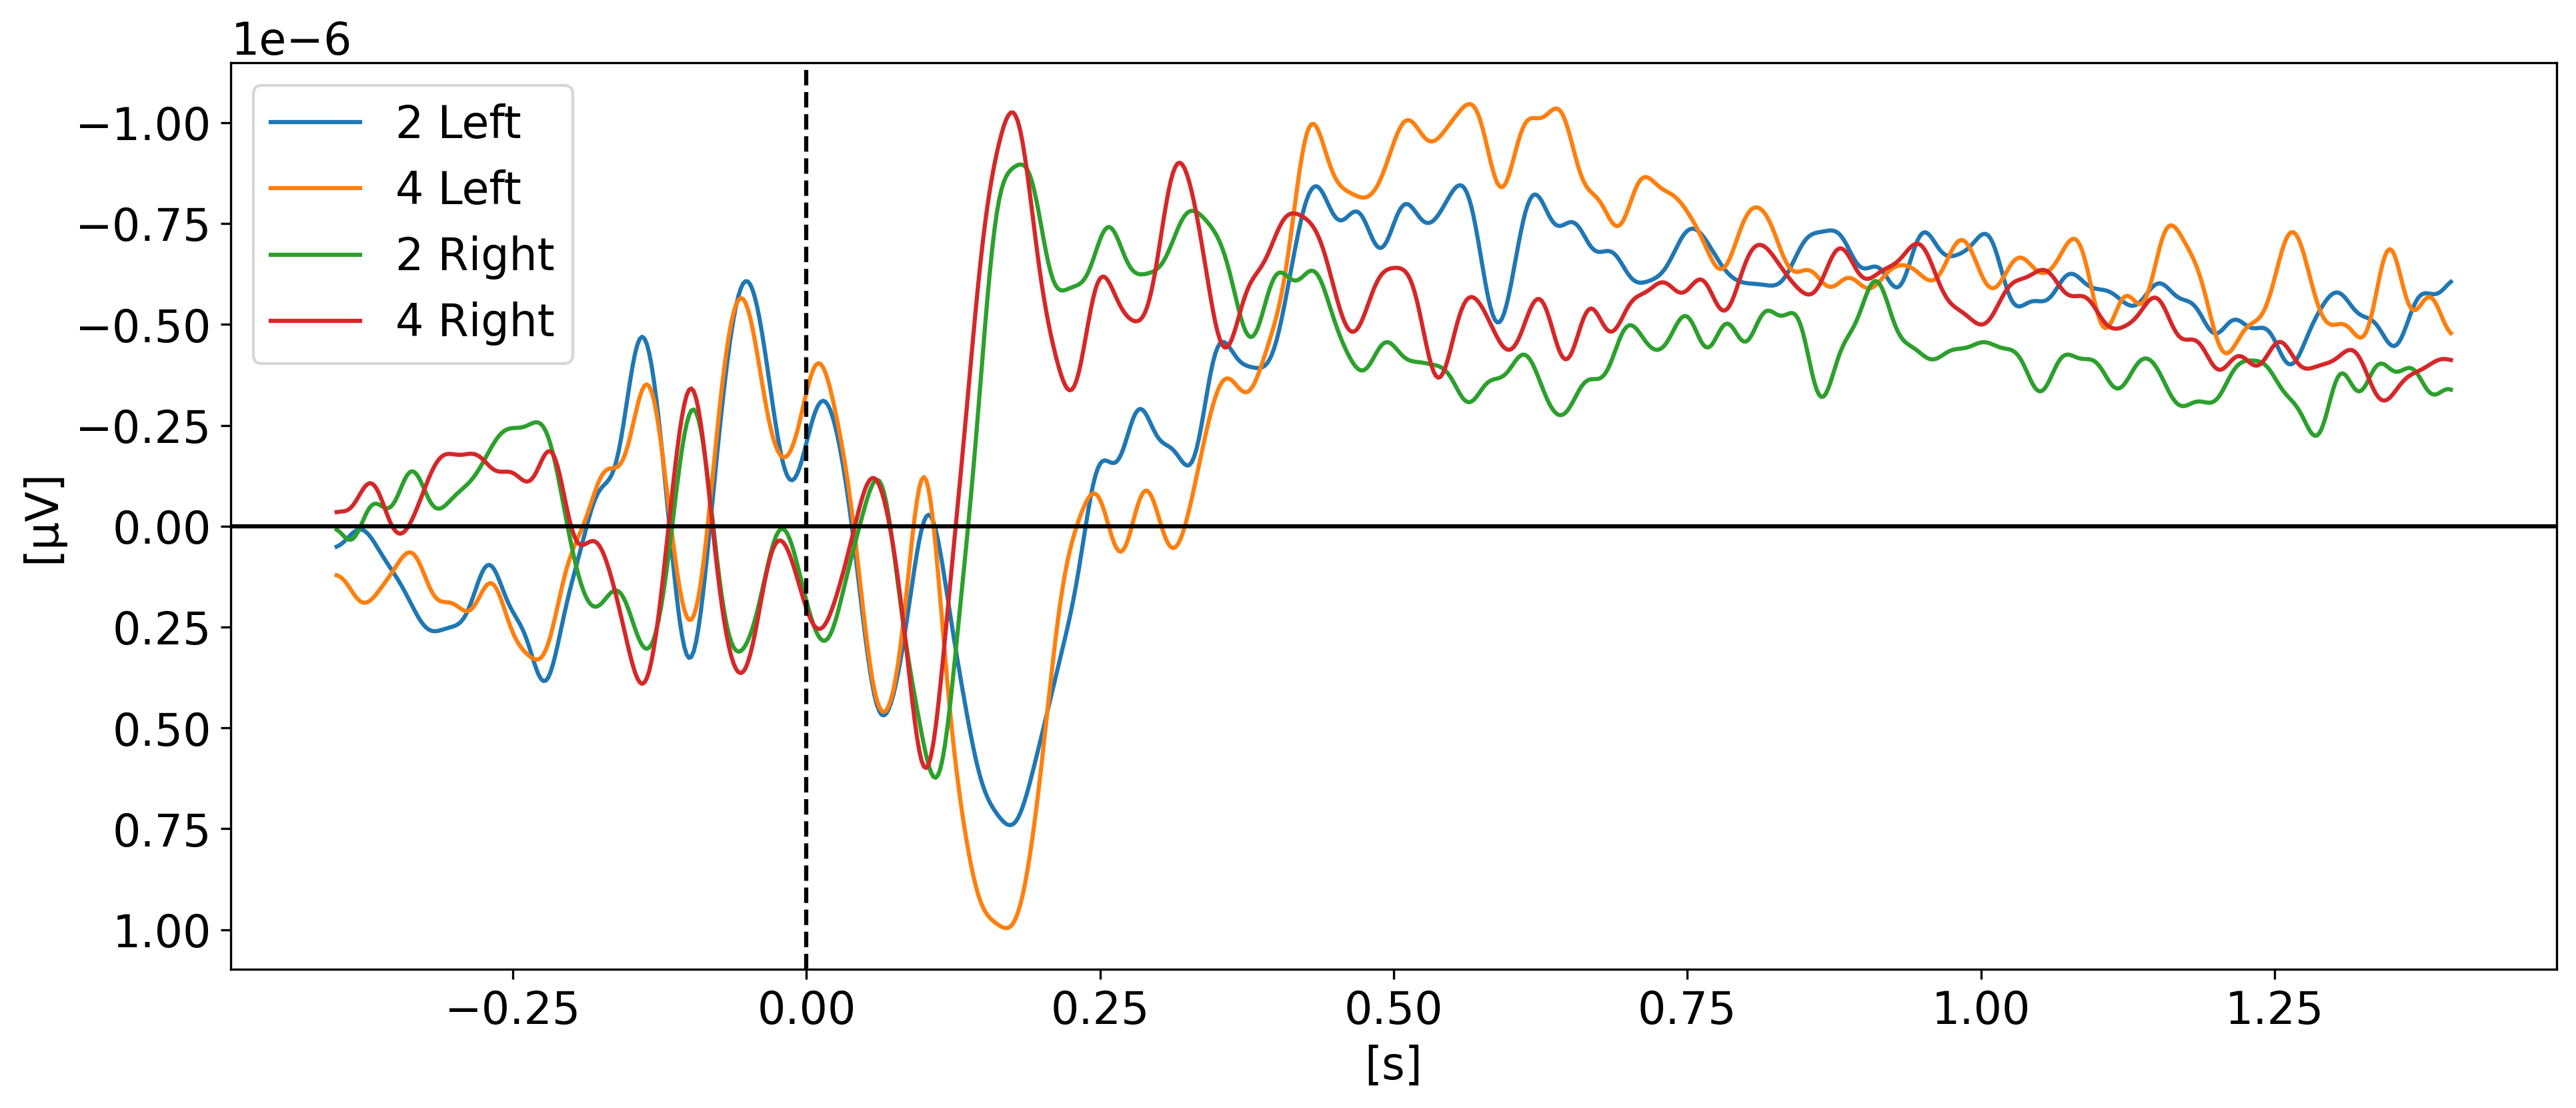

In [13]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, cda_all['2']['left'].mean(0), label='2 Left')
plt.plot(times, cda_all['4']['left'].mean(0), label='4 Left')
plt.plot(times, cda_all['2']['right'].mean(0), label='2 Right')
plt.plot(times, cda_all['4']['right'].mean(0), label='4 Right')
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.savefig("./Hakim-2019_CDA-reprod-leftright.png", dpi=300, format='png')

# Bipolar Exploration

In [17]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

# --------------------------
triggers['2'] = [2, 3]
triggers['4'] = [4, 5]

triggers['left'] = [3, 5]   #[2, 4]
triggers['right'] = [2, 4]  #[3, 5]

triggers['good'] = [91]
triggers['bad'] = [90]

# Labels
conds = ['2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['O2', 'PO4', 'PO8', 'P4', 'P8']
chan_left = ['O1', 'PO3', 'PO7', 'P3', 'P7']

# Epoch Information
epoch_length = 1.4
epoch_tmin = -0.4
baseline_corr = (-0.4, 0)

# CDA main variable!
cda_dict = dict()
cda_dict_clean = dict()
epochs_dict_all = dict()
report = prep_report(conds, sides, perfs)


#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
experiences = ['Exp1a', 'Exp1b', 'Exp2a', 'Exp2b'] 

eegfiles = []
for cur_exp in experiences:
    folderpath = '/Volumes/Nick - Data/CDA Datasets/Hakim 2019/{}/EEGData/**/*.vhdr'.format(cur_exp)
    for filepath in glob.glob(folderpath, recursive=True):
        eegfiles.append(filepath)

for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_brainvision(filepath, preload=True)
        
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    preproc = raw

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Chan Pairs
    chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

    for i, chan in enumerate(chan_right):
        preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
        #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

    preproc = preproc.pick_channels(chan_pairs)
    
    # Get events
    events = mne.events_from_annotations(preproc)
    events = events[0]
    
    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    epochs_dict_all[filename] = epochs_dict
    
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    #cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['2']['left']['good'].times

print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: 10_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/10/10_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5127809  =      0.000 ... 10255.618 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5127810
    Range : 0 ... 5127809 =      0.000 ... 10255.618 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5127810
    Range : 0 ... 5127809 =      0.000 ... 10255.618 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4493110
    Range : 0 ... 4493109 =      0.000 ...  8986.218 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4493110
    Range : 0 ... 4493109 =      0.000 ...  8986.218 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4493110
    Range : 0 ... 4493109 =      0.000 ...  8986.218 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4493110
    Range : 0 ... 4493109 =      0.000 ...  8986.218 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4493110


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4485930
    Range : 0 ... 4485929 =      0.000 ...  8971.858 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4485930
    Range : 0 ... 4485929 =      0.000 ...  8971.858 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4485930
    Range : 0 ... 4485929 =      0.000 ...  8971.858 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4485930
    Range : 0 ... 4485929 =      0.000 ...  8971.858 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4485930


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5127150
    Range : 0 ... 5127149 =      0.000 ... 10254.298 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5127150
    Range : 0 ... 5127149 =      0.000 ... 10254.298 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5535680
    Range : 0 ... 5535679 =      0.000 ... 11071.358 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5535680
    Range : 0 ... 5535679 =      0.000 ... 11071.358 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4127860
    Range : 0 ... 4127859 =      0.000 ...  8255.718 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4127860
    Range : 0 ... 4127859 =      0.000 ...  8255.718 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4657960
    Range : 0 ... 4657959 =      0.000 ...  9315.918 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4657960
    Range : 0 ... 4657959 =      0.000 ...  9315.918 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4657960
    Range : 0 ... 4657959 =      0.000 ...  9315.918 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4657960
    Range : 0 ... 4657959 =      0.000 ...  9315.918 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4657960


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3989100
    Range : 0 ... 3989099 =      0.000 ...  7978.198 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3989100
    Range : 0 ... 3989099 =      0.000 ...  7978.198 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4166670
    Range : 0 ... 4166669 =      0.000 ...  8333.338 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4166670
    Range : 0 ... 4166669 =      0.000 ...  8333.338 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4689050
    Range : 0 ... 4689049 =      0.000 ...  9378.098 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4689050
    Range : 0 ... 4689049 =      0.000 ...  9378.098 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4232320
    Range : 0 ... 4232319 =      0.000 ...  8464.638 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4232320
    Range : 0 ... 4232319 =      0.000 ...  8464.638 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4232320
    Range : 0 ... 4232319 =      0.000 ...  8464.638 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4232320
    Range : 0 ... 4232319 =      0.000 ...  8464.638 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4232320


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4362310
    Range : 0 ... 4362309 =      0.000 ...  8724.618 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4362310
    Range : 0 ... 4362309 =      0.000 ...  8724.618 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4362310
    Range : 0 ... 4362309 =      0.000 ...  8724.618 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4362310

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5455420
    Range : 0 ... 5455419 =      0.000 ... 10910.838 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5455420
    Range : 0 ... 5455419 =      0.000 ... 10910.838 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5450730
    Range : 0 ... 5450729 =      0.000 ... 10901.458 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5450730
    Range : 0 ... 5450729 =      0.000 ... 10901.458 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5826980
    Range : 0 ... 5826979 =      0.000 ... 11653.958 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5826980
    Range : 0 ... 5826979 =      0.000 ... 11653.958 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4759720
    Range : 0 ... 4759719 =      0.000 ...  9519.438 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4759720
    Range : 0 ... 4759719 =      0.000 ...  9519.438 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4397370
    Range : 0 ... 4397369 =      0.000 ...  8794.738 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4397370
    Range : 0 ... 4397369 =      0.000 ...  8794.738 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3845740
    Range : 0 ... 3845739 =      0.000 ...  7691.478 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3845740
    Range : 0 ... 3845739 =      0.000 ...  7691.478 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3845740
    Range : 0 ... 3845739 =      0.000 ...  7691.478 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3845740
    Range : 0 ... 3845739 =      0.000 ...  7691.478 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4395310
    Range : 0 ... 4395309 =      0.000 ...  8790.618 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4395310
    Range : 0 ... 4395309 =      0.000 ...  8790.618 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4445530
    Range : 0 ... 4445529 =      0.000 ...  8891.058 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4445530
    Range : 0 ... 4445529 =      0.000 ...  8891.058 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4211880
    Range : 0 ... 4211879 =      0.000 ...  8423.758 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4211880
    Range : 0 ... 4211879 =      0.000 ...  8423.758 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4250740
    Range : 0 ... 4250739 =      0.000 ...  8501.478 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4250740
    Range : 0 ... 4250739 =      0.000 ...  8501.478 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3998260
    Range : 0 ... 3998259 =      0.000 ...  7996.518 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3998260
    Range : 0 ... 3998259 =      0.000 ...  7996.518 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4527430
    Range : 0 ... 4527429 =      0.000 ...  9054.858 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4527430
    Range : 0 ... 4527429 =      0.000 ...  9054.858 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3913840
    Range : 0 ... 3913839 =      0.000 ...  7827.678 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3913840
    Range : 0 ... 3913839 =      0.000 ...  7827.678 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4048380
    Range : 0 ... 4048379 =      0.000 ...  8096.758 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4048380
    Range : 0 ... 4048379 =      0.000 ...  8096.758 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4048380
    Range : 0 ... 4048379 =      0.000 ...  8096.758 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4048380
    Range : 0 ... 4048379 =      0.000 ...  8096.758 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4048380


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4536890
    Range : 0 ... 4536889 =      0.000 ...  9073.778 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4536890
    Range : 0 ... 4536889 =      0.000 ...  9073.778 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4459320
    Range : 0 ... 4459319 =      0.000 ...  8918.638 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4459320
    Range : 0 ... 4459319 =      0.000 ...  8918.638 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4459320
    Range : 0 ... 4459319 =      0.000 ...  8918.638 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4459320
    Range : 0 ... 4459319 =      0.000 ...  8918.638 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4459320


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5013620
    Range : 0 ... 5013619 =      0.000 ... 10027.238 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5013620
    Range : 0 ... 5013619 =      0.000 ... 10027.238 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5013620
    Range : 0 ... 5013619 =      0.000 ... 10027.238 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5013620
    Range : 0 ... 5013619 =      0.000 ... 10027.238 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5013620


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4531800
    Range : 0 ... 4531799 =      0.000 ...  9063.598 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4531800
    Range : 0 ... 4531799 =      0.000 ...  9063.598 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4531800
    Range : 0 ... 4531799 =      0.000 ...  9063.598 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4531800
    Range : 0 ... 4531799 =      0.000 ...  9063.598 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4531800


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3774000
    Range : 0 ... 3773999 =      0.000 ...  7547.998 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3774000
    Range : 0 ... 3773999 =      0.000 ...  7547.998 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3169620
    Range : 0 ... 3169619 =      0.000 ...  6339.238 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3169620
    Range : 0 ... 3169619 =      0.000 ...  6339.238 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3169620
    Range : 0 ... 3169619 =      0.000 ...  6339.238 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3169620
    Range : 0 ... 3169619 =      0.000 ...  6339.238 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3169620


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4137940
    Range : 0 ... 4137939 =      0.000 ...  8275.878 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4137940
    Range : 0 ... 4137939 =      0.000 ...  8275.878 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4137940
    Range : 0 ... 4137939 =      0.000 ...  8275.878 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4137940
    Range : 0 ... 4137939 =      0.000 ...  8275.878 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4137940


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4578270
    Range : 0 ... 4578269 =      0.000 ...  9156.538 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4578270
    Range : 0 ... 4578269 =      0.000 ...  9156.538 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4592130
    Range : 0 ... 4592129 =      0.000 ...  9184.258 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4592130
    Range : 0 ... 4592129 =      0.000 ...  9184.258 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3984580
    Range : 0 ... 3984579 =      0.000 ...  7969.158 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3984580
    Range : 0 ... 3984579 =      0.000 ...  7969.158 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3984580
    Range : 0 ... 3984579 =      0.000 ...  7969.158 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3984580
    Range : 0 ... 3984579 =      0.000 ...  7969.158 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3984580


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231000
    Range : 0 ... 4230999 =      0.000 ...  8461.998 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231000
    Range : 0 ... 4230999 =      0.000 ...  8461.998 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231000
    Range : 0 ... 4230999 =      0.000 ...  8461.998 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231000
    Range : 0 ... 4230999 =      0.000 ...  8461.998 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231000


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3998610
    Range : 0 ... 3998609 =      0.000 ...  7997.218 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3998610
    Range : 0 ... 3998609 =      0.000 ...  7997.218 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3495140
    Range : 0 ... 3495139 =      0.000 ...  6990.278 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3495140
    Range : 0 ... 3495139 =      0.000 ...  6990.278 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3495140
    Range : 0 ... 3495139 =      0.000 ...  6990.278 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3495140
    Range : 0 ... 3495139 =      0.000 ...  6990.278 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3495140


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4211460
    Range : 0 ... 4211459 =      0.000 ...  8422.918 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4211460
    Range : 0 ... 4211459 =      0.000 ...  8422.918 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5158480
    Range : 0 ... 5158479 =      0.000 ... 10316.958 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5158480
    Range : 0 ... 5158479 =      0.000 ... 10316.958 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5314850
    Range : 0 ... 5314849 =      0.000 ... 10629.698 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5314850
    Range : 0 ... 5314849 =      0.000 ... 10629.698 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5314850
    Range : 0 ... 5314849 =      0.000 ... 10629.698 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5314850
    Range : 0 ... 5314849 =      0.000 ... 10629.698 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5314850


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4164820
    Range : 0 ... 4164819 =      0.000 ...  8329.638 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4164820
    Range : 0 ... 4164819 =      0.000 ...  8329.638 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter sett

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4109390
    Range : 0 ... 4109389 =      0.000 ...  8218.778 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4109390
    Range : 0 ... 4109389 =      0.000 ...  8218.778 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4109390
    Range : 0 ... 4109389 =      0.000 ...  8218.778 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4109390
    Range : 0 ... 4109389 =      0.000 ...  8218.778 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4109390


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4172850
    Range : 0 ... 4172849 =      0.000 ...  8345.698 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4172850
    Range : 0 ... 4172849 =      0.000 ...  8345.698 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4172850
    Range : 0 ... 4172849 =      0.000 ...  8345.698 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4172850
    Range : 0 ... 4172849 =      0.000 ...  8345.698 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4172850


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4698380
    Range : 0 ... 4698379 =      0.000 ...  9396.758 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4698380
    Range : 0 ... 4698379 =      0.000 ...  9396.758 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4698380
    Range : 0 ... 4698379 =      0.000 ...  9396.758 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4698380
    Range : 0 ... 4698379 =      0.000 ...  9396.758 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4698380


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4327930
    Range : 0 ... 4327929 =      0.000 ...  8655.858 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4327930
    Range : 0 ... 4327929 =      0.000 ...  8655.858 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4327930
    Range : 0 ... 4327929 =      0.000 ...  8655.858 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4327930
    Range : 0 ... 4327929 =      0.000 ...  8655.858 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4327930


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4514670
    Range : 0 ... 4514669 =      0.000 ...  9029.338 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4514670
    Range : 0 ... 4514669 =      0.000 ...  9029.338 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4514670
    Range : 0 ... 4514669 =      0.000 ...  9029.338 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4514670
    Range : 0 ... 4514669 =      0.000 ...  9029.338 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4514670


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4206830
    Range : 0 ... 4206829 =      0.000 ...  8413.658 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4206830
    Range : 0 ... 4206829 =      0.000 ...  8413.658 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4206830
    Range : 0 ... 4206829 =      0.000 ...  8413.658 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4206830
    Range : 0 ... 4206829 =      0.000 ...  8413.658 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4206830


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3887270
    Range : 0 ... 3887269 =      0.000 ...  7774.538 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3887270
    Range : 0 ... 3887269 =      0.000 ...  7774.538 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3887270
    Range : 0 ... 3887269 =      0.000 ...  7774.538 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3887270
    Range : 0 ... 3887269 =      0.000 ...  7774.538 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3887270


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088670
    Range : 0 ... 4088669 =      0.000 ...  8177.338 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088670
    Range : 0 ... 4088669 =      0.000 ...  8177.338 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4824530
    Range : 0 ... 4824529 =      0.000 ...  9649.058 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4824530
    Range : 0 ... 4824529 =      0.000 ...  9649.058 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4420010
    Range : 0 ... 4420009 =      0.000 ...  8840.018 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4420010
    Range : 0 ... 4420009 =      0.000 ...  8840.018 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3611160
    Range : 0 ... 3611159 =      0.000 ...  7222.318 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3611160
    Range : 0 ... 3611159 =      0.000 ...  7222.318 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3611160
    Range : 0 ... 3611159 =      0.000 ...  7222.318 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3611160
    Range : 0 ... 3611159 =      0.000 ...  7222.318 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3611160


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4121120
    Range : 0 ... 4121119 =      0.000 ...  8242.238 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4121120
    Range : 0 ... 4121119 =      0.000 ...  8242.238 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4121120
    Range : 0 ... 4121119 =      0.000 ...  8242.238 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4121120
    Range : 0 ... 4121119 =      0.000 ...  8242.238 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4121120


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5176380
    Range : 0 ... 5176379 =      0.000 ... 10352.758 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5176380
    Range : 0 ... 5176379 =      0.000 ... 10352.758 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319190
    Range : 0 ... 4319189 =      0.000 ...  8638.378 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319190
    Range : 0 ... 4319189 =      0.000 ...  8638.378 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319190
    Range 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3513660
    Range : 0 ... 3513659 =      0.000 ...  7027.318 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3513660
    Range : 0 ... 3513659 =      0.000 ...  7027.318 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3513660
    Range : 0 ... 3513659 =      0.000 ...  7027.318 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3513660
    Range : 0 ... 3513659 =      0.000 ...  7027.318 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3513660


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598690
    Range : 0 ... 3598689 =      0.000 ...  7197.378 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598690
    Range : 0 ... 3598689 =      0.000 ...  7197.378 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598690
    Range : 0 ... 3598689 =      0.000 ...  7197.378 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598690
    Range : 0 ... 3598689 =      0.000 ...  7197.378 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598690


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4375330
    Range : 0 ... 4375329 =      0.000 ...  8750.658 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4375330
    Range : 0 ... 4375329 =      0.000 ...  8750.658 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4371370
    Range : 0 ... 4371369 =      0.000 ...  8742.738 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4371370
    Range : 0 ... 4371369 =      0.000 ...  8742.738 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4151190
    Range : 0 ... 4151189 =      0.000 ...  8302.378 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4151190
    Range : 0 ... 4151189 =      0.000 ...  8302.378 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3923550
    Range : 0 ... 3923549 =      0.000 ...  7847.098 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3923550
    Range : 0 ... 3923549 =      0.000 ...  7847.098 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3923550
    Range : 0 ... 3923549 =      0.000 ...  7847.098 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3923550
    Range : 0 ... 3923549 =      0.000 ...  7847.098 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3923550


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4207210
    Range : 0 ... 4207209 =      0.000 ...  8414.418 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4207210
    Range : 0 ... 4207209 =      0.000 ...  8414.418 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4123610
    Range : 0 ... 4123609 =      0.000 ...  8247.218 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4123610
    Range : 0 ... 4123609 =      0.000 ...  8247.218 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231530
    Range : 0 ... 4231529 =      0.000 ...  8463.058 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231530
    Range : 0 ... 4231529 =      0.000 ...  8463.058 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231530
    Range : 0 ... 4231529 =      0.000 ...  8463.058 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231530
    Range : 0 ... 4231529 =      0.000 ...  8463.058 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4231530


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5702880
    Range : 0 ... 5702879 =      0.000 ... 11405.758 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5702880
    Range : 0 ... 5702879 =      0.000 ... 11405.758 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4115520
    Range : 0 ... 4115519 =      0.000 ...  8231.038 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4115520
    Range : 0 ... 4115519 =      0.000 ...  8231.038 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088060
    Range : 0 ... 4088059 =      0.000 ...  8176.118 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088060
    Range : 0 ... 4088059 =      0.000 ...  8176.118 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088060
    Range : 0 ... 4088059 =      0.000 ...  8176.118 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088060
    Range : 0 ... 4088059 =      0.000 ...  8176.118 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4088060


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3743530
    Range : 0 ... 3743529 =      0.000 ...  7487.058 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3743530
    Range : 0 ... 3743529 =      0.000 ...  7487.058 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3743530
    Range : 0 ... 3743529 =      0.000 ...  7487.058 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3743530
    Range : 0 ... 3743529 =      0.000 ...  7487.058 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3743530


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3829050
    Range : 0 ... 3829049 =      0.000 ...  7658.098 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3829050
    Range : 0 ... 3829049 =      0.000 ...  7658.098 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3829050
    Range : 0 ... 3829049 =      0.000 ...  7658.098 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3829050
    Range : 0 ... 3829049 =      0.000 ...  7658.098 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3829050


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3895530
    Range : 0 ... 3895529 =      0.000 ...  7791.058 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3895530
    Range : 0 ... 3895529 =      0.000 ...  7791.058 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3895530
    Range : 0 ... 3895529 =      0.000 ...  7791.058 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3895530
    Range : 0 ... 3895529 =      0.000 ...  7791.058 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3895530


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3726490
    Range : 0 ... 3726489 =      0.000 ...  7452.978 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3726490
    Range : 0 ... 3726489 =      0.000 ...  7452.978 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4111020
    Range : 0 ... 4111019 =      0.000 ...  8222.038 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4111020
    Range : 0 ... 4111019 =      0.000 ...  8222.038 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4111020
    Range : 0 ... 4111019 =      0.000 ...  8222.038 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4111020
    Range : 0 ... 4111019 =      0.000 ...  8222.038 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4111020


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598130
    Range : 0 ... 3598129 =      0.000 ...  7196.258 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598130
    Range : 0 ... 3598129 =      0.000 ...  7196.258 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598130
    Range : 0 ... 3598129 =      0.000 ...  7196.258 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598130
    Range : 0 ... 3598129 =      0.000 ...  7196.258 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3598130


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3515380
    Range : 0 ... 3515379 =      0.000 ...  7030.758 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3515380
    Range : 0 ... 3515379 =      0.000 ...  7030.758 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3515380
    Range : 0 ... 3515379 =      0.000 ...  7030.758 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3515380
    Range : 0 ... 3515379 =      0.000 ...  7030.758 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3515380


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3954390
    Range : 0 ... 3954389 =      0.000 ...  7908.778 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3954390
    Range : 0 ... 3954389 =      0.000 ...  7908.778 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1726290
    Range : 0 ... 1726289 =      0.000 ...  3452.578 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1726290
    Range : 0 ... 1726289 =      0.000 ...  3452.578 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1726290
    Range : 0 ... 1726289 =      0.000 ...  3452.578 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1726290
    Range : 0 ... 1726289 =      0.000 ...  3452.578 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1726290


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3567820
    Range : 0 ... 3567819 =      0.000 ...  7135.638 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3567820
    Range : 0 ... 3567819 =      0.000 ...  7135.638 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3567820
    Range : 0 ... 3567819 =      0.000 ...  7135.638 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3567820
    Range : 0 ... 3567819 =      0.000 ...  7135.638 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3567820


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3588100
    Range : 0 ... 3588099 =      0.000 ...  7176.198 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3588100
    Range : 0 ... 3588099 =      0.000 ...  7176.198 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3588100
    Range : 0 ... 3588099 =      0.000 ...  7176.198 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3588100
    Range : 0 ... 3588099 =      0.000 ...  7176.198 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3588100


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3622330
    Range : 0 ... 3622329 =      0.000 ...  7244.658 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3622330
    Range : 0 ... 3622329 =      0.000 ...  7244.658 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3622330
    Range : 0 ... 3622329 =      0.000 ...  7244.658 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3622330
    Range : 0 ... 3622329 =      0.000 ...  7244.658 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3622330


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3837130
    Range : 0 ... 3837129 =      0.000 ...  7674.258 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3837130
    Range : 0 ... 3837129 =      0.000 ...  7674.258 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3837130
    Range : 0 ... 3837129 =      0.000 ...  7674.258 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3837130
    Range : 0 ... 3837129 =      0.000 ...  7674.258 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3837130


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4160050
    Range : 0 ... 4160049 =      0.000 ...  8320.098 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4160050
    Range : 0 ... 4160049 =      0.000 ...  8320.098 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4160050
    Range : 0 ... 4160049 =      0.000 ...  8320.098 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4160050
    Range : 0 ... 4160049 =      0.000 ...  8320.098 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4160050


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3558690
    Range : 0 ... 3558689 =      0.000 ...  7117.378 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3558690
    Range : 0 ... 3558689 =      0.000 ...  7117.378 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3558690
    Range : 0 ... 3558689 =      0.000 ...  7117.378 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3558690
    Range : 0 ... 3558689 =      0.000 ...  7117.378 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3558690


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3832000
    Range : 0 ... 3831999 =      0.000 ...  7663.998 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3832000
    Range : 0 ... 3831999 =      0.000 ...  7663.998 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3832000
    Range : 0 ... 3831999 =      0.000 ...  7663.998 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3832000
    Range : 0 ... 3831999 =      0.000 ...  7663.998 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3832000


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3673900
    Range : 0 ... 3673899 =      0.000 ...  7347.798 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3673900
    Range : 0 ... 3673899 =      0.000 ...  7347.798 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3673900
    Range : 0 ... 3673899 =      0.000 ...  7347.798 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3673900
    Range : 0 ... 3673899 =      0.000 ...  7347.798 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3673900


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3823690
    Range : 0 ... 3823689 =      0.000 ...  7647.378 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3823690
    Range : 0 ... 3823689 =      0.000 ...  7647.378 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3823690
    Range : 0 ... 3823689 =      0.000 ...  7647.378 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3823690
    Range : 0 ... 3823689 =      0.000 ...  7647.378 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3823690


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3351050
    Range : 0 ... 3351049 =      0.000 ...  6702.098 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3351050
    Range : 0 ... 3351049 =      0.000 ...  6702.098 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3351050
    Range : 0 ... 3351049 =      0.000 ...  6702.098 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3351050
    Range : 0 ... 3351049 =      0.000 ...  6702.098 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3351050


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3814740
    Range : 0 ... 3814739 =      0.000 ...  7629.478 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3814740
    Range : 0 ... 3814739 =      0.000 ...  7629.478 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3814740
    Range : 0 ... 3814739 =      0.000 ...  7629.478 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3814740
    Range : 0 ... 3814739 =      0.000 ...  7629.478 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3814740


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4062220
    Range : 0 ... 4062219 =      0.000 ...  8124.438 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4062220
    Range : 0 ... 4062219 =      0.000 ...  8124.438 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4062220
    Range : 0 ... 4062219 =      0.000 ...  8124.438 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4062220
    Range : 0 ... 4062219 =      0.000 ...  8124.438 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4062220


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3794670
    Range : 0 ... 3794669 =      0.000 ...  7589.338 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3794670
    Range : 0 ... 3794669 =      0.000 ...  7589.338 secs
Ready.
Added the following bipolar channel

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3457220
    Range : 0 ... 3457219 =      0.000 ...  6914.438 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3457220
    Range : 0 ... 3457219 =      0.000 ...  6914.438 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3457220
    Range : 0 ... 3457219 =      0.000 ...  6914.438 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3457220
    Range : 0 ... 3457219 =      0.000 ...  6914.438 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3457220


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3617810
    Range : 0 ... 3617809 =      0.000 ...  7235.618 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3617810
    Range : 0 ... 3617809 =      0.000 ...  7235.618 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3617810
    Range : 0 ... 3617809 =      0.000 ...  7235.618 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3617810
    Range : 0 ... 3617809 =      0.000 ...  7235.618 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3617810


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319080
    Range : 0 ... 4319079 =      0.000 ...  8638.158 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319080
    Range : 0 ... 4319079 =      0.000 ...  8638.158 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319080
    Range : 0 ... 4319079 =      0.000 ...  8638.158 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319080
    Range : 0 ... 4319079 =      0.000 ...  8638.158 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4319080


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3952140
    Range : 0 ... 3952139 =      0.000 ...  7904.278 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3952140
    Range : 0 ... 3952139 =      0.000 ...  7904.278 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3952140
    Range : 0 ... 3952139 =      0.000 ...  7904.278 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3952140
    Range : 0 ... 3952139 =      0.000 ...  7904.278 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3952140


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3700610
    Range : 0 ... 3700609 =      0.000 ...  7401.218 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3700610
    Range : 0 ... 3700609 =      0.000 ...  7401.218 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3700610
    Range : 0 ... 3700609 =      0.000 ...  7401.218 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3700610
    Range : 0 ... 3700609 =      0.000 ...  7401.218 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3700610


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, N

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20656/2622220480.py:56: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3943790
    Range : 0 ... 3943789 =      0.000 ...  7887.578 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3943790
    Range : 0 ... 3943789 =      0.000 ...  7887.578 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3943790
    Range : 0 ... 3943789 =      0.000 ...  7887.578 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3943790
    Range : 0 ... 3943789 =      0.000 ...  7887.578 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3943790


,2,4,left,right,good,bad,2-left,2-left-good,2-good,2-left-bad,...,4-left,4-left-good,4-good,4-left-bad,4-bad,4-right,4-right-good,4-right-bad,checksum,notes
10_WM_att_NHKA.vhdr,400,400,400,400,571,229,200,154,317,46,...,200,126,254,74,146,200,128,72,1,
11_WM_att_NHKA.vhdr,400,400,400,400,665,135,200,190,371,10,...,200,140,294,60,106,200,154,46,1,
12_WM_att_NHKA.vhdr,400,400,400,400,723,77,200,192,380,8,...,200,175,343,25,57,200,168,32,1,
13_WM_att_NHKA.vhdr,400,400,400,400,620,180,200,169,348,31,...,200,136,272,64,128,200,136,64,1,
15_WM_att_NHKA.vhdr,400,400,400,400,484,316,200,140,268,60,...,200,113,216,87,184,200,103,97,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5_KiNi4.vhdr,400,400,400,400,662,138,200,174,362,26,...,200,147,300,53,100,200,153,47,1,
50_KiNi4.vhdr,400,400,400,400,646,154,200,175,355,25,...,200,139,291,61,109,200,152,48,1,
6_KiNi4.vhdr,400,400,400,400,598,202,200,163,339,37,...,200,121,259,79,141,200,138,62,1,
7_KiNi4.vhdr,400,400,400,400,421,379,200,112,228,88,...,200,102,193,98,207,200,91,109,1,


In [18]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

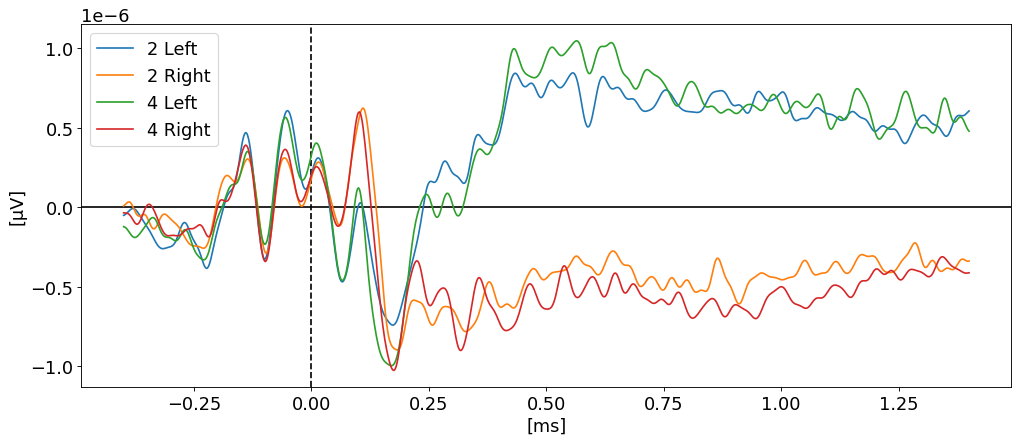

In [20]:
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.plot(times, cda_all['2']['left'].mean(0), label='2 Left')
plt.plot(times, cda_all['2']['right'].mean(0), label='2 Right')
plt.plot(times, cda_all['4']['left'].mean(0), label='4 Left')
plt.plot(times, cda_all['4']['right'].mean(0), label='4 Right')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()